<a href="https://colab.research.google.com/github/matinmazid/York_ML_certificate/blob/master/ss_feature_importance_blogpost_july_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature importance

This notebook is part of the following blogpost: https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

# Install depencencies


In [ ]:
#Install non-standard packages (assuming jupyter notebook)
!pip install shap==0.46
!pip install lime
!pip install scikit-learn==1.2.2
!pip install --upgrade eli5



# Import packages

In [59]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

#scikit-learn package (https://pypi.org/project/scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#scikit-learn package (https://pypi.org/project/scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, make_scorer # Import make_scorer directly from sklearn.metrics
#from sklearn.metrics.scorer import make_scorer # This line is removed


#eli5 package (https://eli5.readthedocs.io/en/latest)
import eli5
from eli5.sklearn import PermutationImportance

#lime package (https://github.com/marcotcr/lime)
import lime
import lime.lime_tabular

#shap package (https://github.com/slundberg/shap)
import shap

In [ ]:
import sklearn

print(sklearn.__version__)

1.2.2


# Load data and train model

In [60]:
#Load Wisconsin diagnostic breast cancer data from UCI #

url_prefix = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
#if url url does not work you can use this mirror instead:
#url_prefix = "http://mlr.cs.umass.edu/ml/machine-learning-databases/"

data_url = url_prefix + "breast-cancer-wisconsin/wdbc.data"

#Define column labels
id_status = ["ID", "diagnosis"]

#Mean, standard error and maximum ('worst') values are available for features
#computed on a collection of cells in a tissue
column_labels = itertools.product(["radius", "texture", "perimeter", "area",
                                  "smoothness", "compactness", "concavity",
                                  "concave_points", "symmetry", "fractal_dim"],
                                 ["mean","std","max"])

column_labels = id_status + [f"{t}_{f}" for f, t in column_labels]

#Read into pandas DataFrame
df = pd.read_csv(data_url, header=None, names = column_labels)

#Define feature set
X = df.drop('ID', axis=1).drop('diagnosis', axis=1)

#Define diagnosis as integer: malignant (1) or benign (0)
y = (df['diagnosis'] == "M")*1

#Split train and test set.
RANDOM_STATE = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

#Train random forest classification model
model = RandomForestClassifier(max_depth=4, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Diagnosis prediction
y_predict = model.predict(X_test)

# Probability of malignant tissue produced by the model
y_prob = [probs[1] for probs in model.predict_proba(X_test)]



In [61]:
y_train.head()

,diagnosis
366,1
86,1
230,1
467,0
138,1


# Evaluate model

Test accuracy: 0.965034965034965


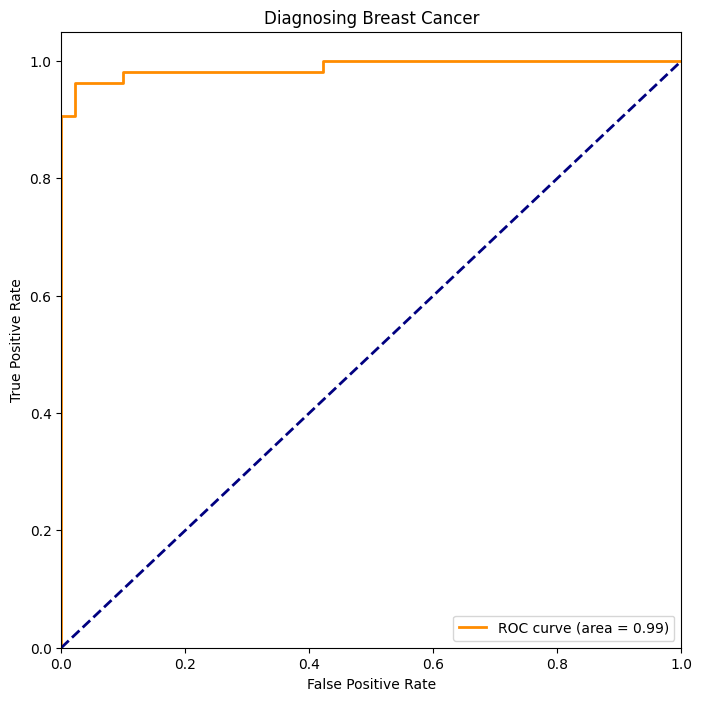

In [62]:
#Accuracy on test set
print(f"Test accuracy: {accuracy_score(y_test, y_predict)}")

# Confusion matrix test set
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['Benign', 'Malignant']
)

# Compute area under the curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#Set default figure size
plt.rcParams['figure.figsize'] = (8,8)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Diagnosing Breast Cancer")
plt.legend(loc="lower right")
plt.show()


# Model-specific feature importance

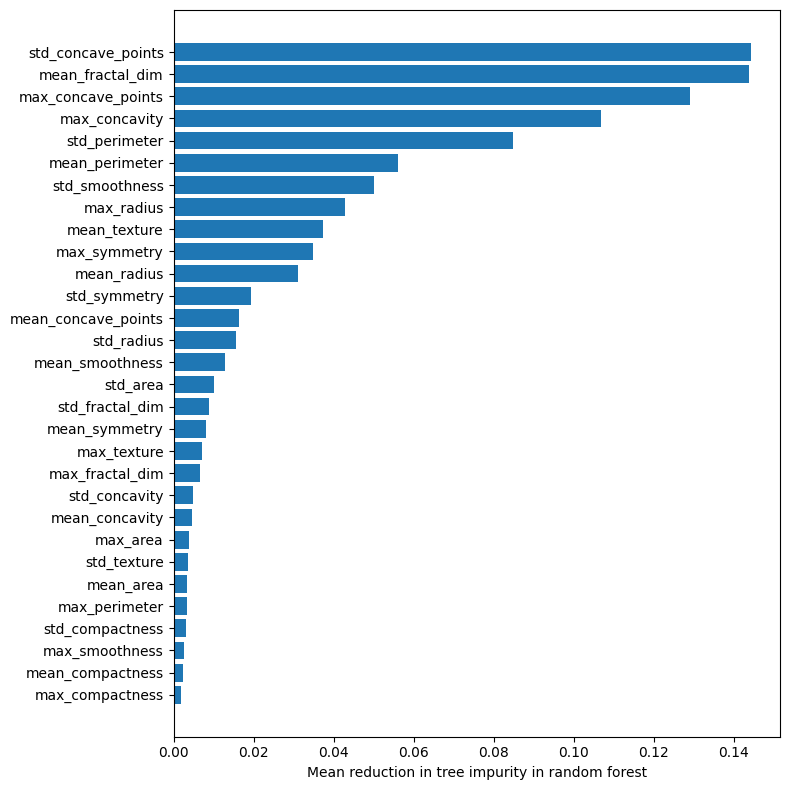

In [63]:
# Feature importance dataframe
imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': model.feature_importances_})

# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)

## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)

# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout()
# Show graphic
plt.show()



# Permutation feature importance

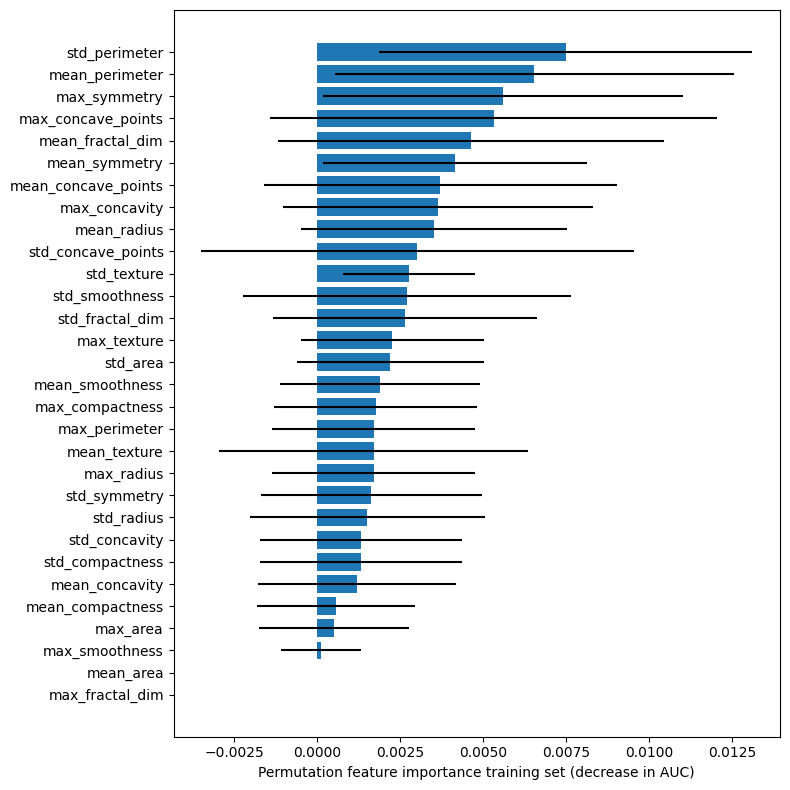

In [65]:
# Feature importance based on TRAINING set

perm_test = PermutationImportance(model, scoring=make_scorer(roc_auc_score),
                                   n_iter=50, random_state=RANDOM_STATE, cv="prefit")

# fit and see the permuation importances
perm_test.fit(X_train, y_train)

imp_df = eli5.explain_weights_df(perm_test)
label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(X_test.columns))], 'feature_name': X_test.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")

# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)


## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci)

# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Permutation feature importance training set (decrease in AUC)")
plt.tight_layout()

# Show graphic
plt.show()



# LIME

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Intercept 0.29049321111511917
Prediction_local [0.82249689]
Right: 0.9849837805657705


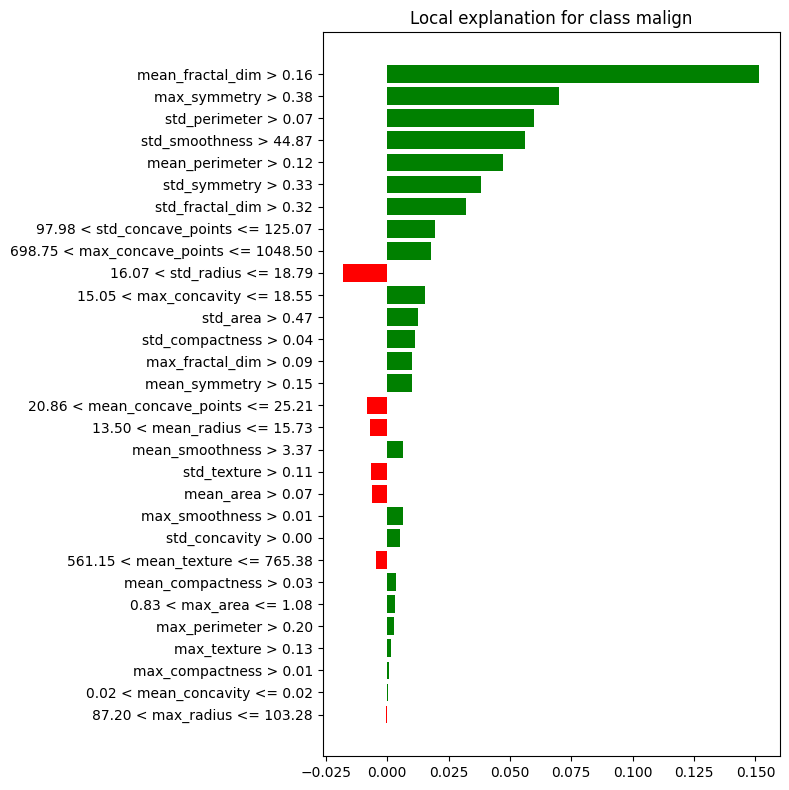

In [66]:
#Explain samples in test set
X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   feature_names=X_train.columns.values,
                                                   discretize_continuous=True,
                                                   class_names=["benign", "malign"],
                                                   mode="classification",
                                                   verbose=True,
                                                   random_state=RANDOM_STATE)

#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain.values[0,:],model.predict_proba,
                                 num_features=30)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

In [67]:
X_explain.iloc[0]

,257
mean_radius,15.32000
std_radius,17.27000
max_radius,103.20000
mean_texture,713.30000
std_texture,0.13350
max_texture,0.22840
mean_perimeter,0.24480
std_perimeter,0.12420
max_perimeter,0.23980
mean_area,0.07596


In [86]:
# explain the model's predictions on test set using SHAP values
# same syntax works for xgboost, LightGBM, CatBoost, and some scikit-learn models
explainer = shap.TreeExplainer(model)

# shap_values consists of a list of two matrices of dimension samplesize x #features
# The first matrix uses average nr of benign samples as base value
# The second matrix which is used below uses average nr of malignant samples as base value
shap_values = explainer(X_train)
expected_value = explainer.expected_value


shap_value = shap_values.values[1]

# Interactive visualization of the explanation of the first subject
# in the test set (X_explain).
# It shows the relative contribution of features to get from the base value of malignant
# samples(average value)
# to the output value (1 in case of malignant sample)
# the numbers at the bottom show the actual values for this sample.
shap.initjs() #initialize javascript in cell
#shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_explain.iloc[0,:])
shap.force_plot(base_value=expected_value[1], shap_values=shap_value[...,0], features=X_train.iloc[1,:], link="logit") # Change this line
#shap.force_plot(base_value=expected_value[0], shap_values=shap_value[...,0]) # Change this line


In [ ]:
explainer.expected_value[0]

0.6315962441314558

In [104]:
shap_values_for_sample

.values =
array([-2.77490414e-02, -1.65688943e-02, -3.10999317e-02, -3.84209476e-02,
        6.11702863e-05, -2.75525120e-03, -3.31694250e-02, -5.51943634e-02,
       -1.11713941e-03,  2.16116206e-04, -4.83671026e-03, -1.44477213e-03,
       -8.31651218e-03, -3.91250851e-02, -1.04108668e-03,  1.97154490e-04,
       -2.65975600e-03,  2.74774557e-03, -2.56967472e-05, -1.36392539e-03,
       -7.10371276e-02, -1.12107886e-02, -7.88554611e-02, -8.78290939e-02,
        1.82974524e-03, -2.07129080e-03, -2.24429825e-02, -9.57319376e-02,
       -1.63256024e-03,  1.72911469e-03])

.base_values =
0.6315962441314558

.data =
array([2.020e+01, 2.683e+01, 1.337e+02, 1.234e+03, 9.905e-02, 1.669e-01,
       1.641e-01, 1.265e-01, 1.875e-01, 6.020e-02, 9.761e-01, 1.892e+00,
       7.128e+00, 1.036e+02, 8.439e-03, 4.674e-02, 5.904e-02, 2.536e-02,
       3.710e-02, 4.286e-03, 2.419e+01, 3.381e+01, 1.600e+02, 1.671e+03,
       1.278e-01, 3.416e-01, 3.703e-01, 2.152e-01, 3.271e-01, 7.632e-02])

In [114]:
#Interactive visualization of all sample/feature Shapley values
#It is possible to show the relative contribution of individual features for all
# samples on the y-axis as well.
#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[0][0,:], X_test.iloc[0,1:])


shap.initjs()
sample_index = 0
# Access the SHAP values for the selected sample and class 0
shap_values_for_sample = shap_values[sample_index].values[:,0]
# Access the features for the selected sample
features_for_sample = X_train.iloc[sample_index]
#shap.force_plot(explainer.expected_value[1], shap_values[:,0,1], X_explain.iloc[1])
shap.force_plot(base_value=explainer.expected_value[0], shap_values=shap_values_for_sample,
                features=features_for_sample, link="logit")


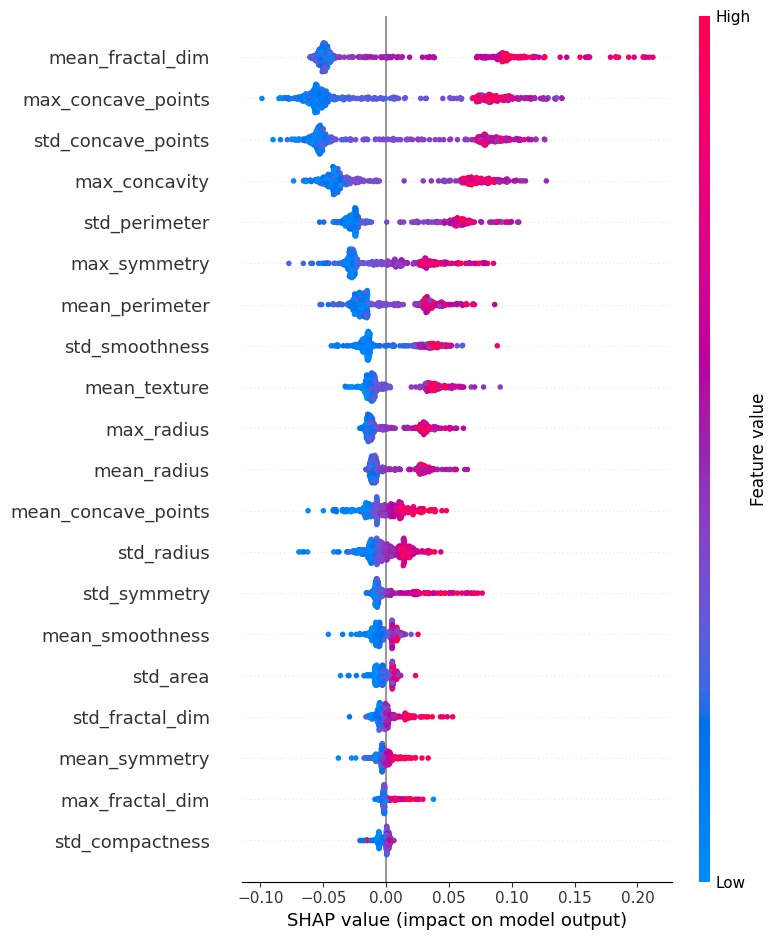

In [94]:
shap.summary_plot(shap_values[...,1], X_train)

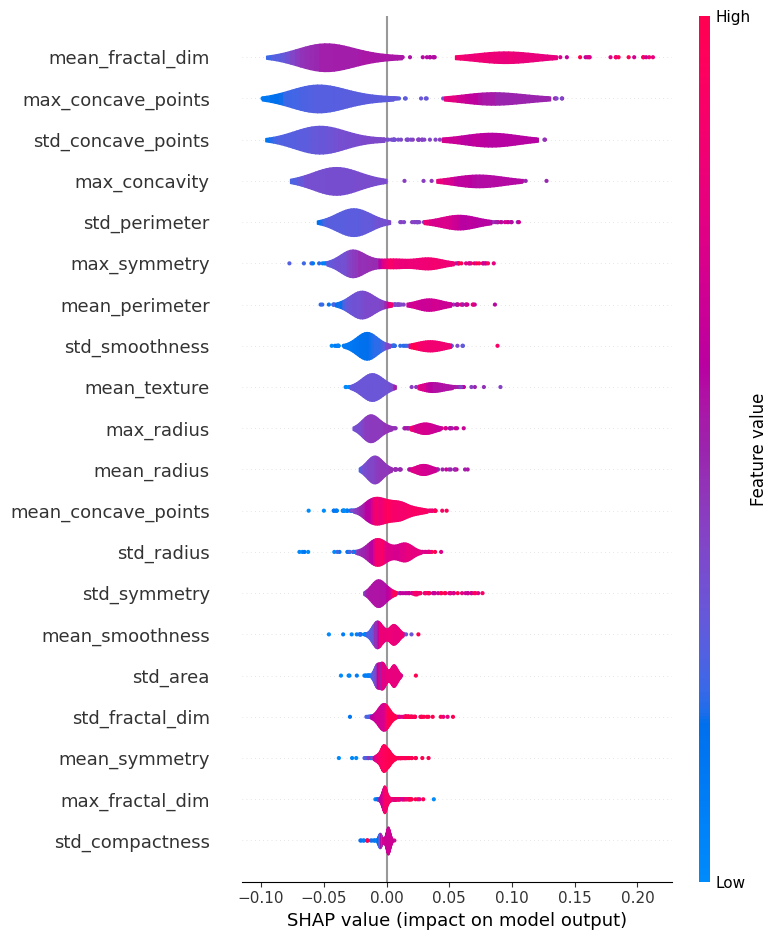

In [98]:
#Same as above, but with violin plots to better see the distribution of shapley values
shap.summary_plot(shap_values[...,1], X_train, plot_type="violin")